In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import multiprocessing
import scipy.special
import numpy as np
import numpy.fft as fft
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')

In [3]:
from conversion import rotation_matrix_fromq,rotation_matrix_from_params,rotation_matrix_to_q,angles_from_q
from utils import to_radian,res_to_rad,ax_to_w,rep_to_angle
from visualize import plot_cost_func,plot_volume,plot_slices
from cost_functions import cf_ssd
from mask import sphere_mask

In [4]:
from rotation_3d import trilinear_interp,volrotate_trilinear,rotate_coords_3d,rotation_matrix_zyx
from rotation_3d import tricubic_derivatives,tricubic_interp,volrotate_tricubic
from rotation_3d import BSpline_coefficients, Bspline_interp_1d, Bspline_interp, BSpline_derivatives, volrotate_bspline
from Gauss_Newton import Gauss_Newton, Gauss_Newton1, print_results,sphere_mask,fourier_filter,get_gradient_P

In [5]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Dropbox/THESIS/Oct_13_navs/'
ranges = ['0_5_to_2_5','3_0_to_5_0']
files = os.listdir(path)
axes_dict = {}
for f in files[1:]:
    rot_ax = f.split('_')[2]
    trans_ax = f.split('_')[10]
    if not axes_dict.has_key(rot_ax):
        axes_dict[rot_ax] = trans_ax
print axes_dict
print axes_dict.keys()

rot_axes = ['xz', 'y', 'yz', 'xy', 'x', 'z']
ax_to_idx = {}
for rot_ax in rot_axes:
    ax_to_idx[rot_ax] = rot_axes.index(rot_ax)
print ax_to_idx

{'xz': 'xy', 'y': 'z', 'yz': 'xy', 'xy': 'xy', 'x': 'z', 'z': 'z'}
['xz', 'y', 'yz', 'xy', 'x', 'z']
{'xy': 3, 'xz': 0, 'yz': 2, 'y': 1, 'x': 4, 'z': 5}


In [6]:
def normalize(volume, scale):
    assert((volume >= 0).all())
    return volume * scale

In [7]:
def Max_displacement(dRM, R_axis, dt):
    rad = 100
    trans_R = rad*np.sqrt(3-np.trace(dRM))
    E_max = np.sqrt(trans_R**2 + 2*trans_R*np.linalg.norm(dt-(dt.T.dot(R_axis))*R_axis) + (dt.T).dot(dt))
    return trans_R, E_max

In [19]:
def RMS_Rotation(dRM):
    return np.arccos((np.trace(dRM)-1)/2.)*180/np.pi

def RMS_Translation(dt):
    t = dt
    return np.sqrt((t.T).dot(t))
def RMS_Translation_R(dRM):
    rad = 100
    A = dRM - np.eye(3)
    return np.sqrt(0.2*rad**2*np.trace((A.T).dot(A)))

def RMS(dRM, dt, res_f):
    rad = 100
    A = dRM - np.eye(3)
    return np.sqrt(0.2*rad**2*np.trace((A.T).dot(A))+ (dt.T).dot(dt))
    
from conversion import rotation_matrix_fromq, rotation_matrix_from_params
def get_true_params(rot_angle,rot_ax):
    wy,wx,wz = ax_to_w(rot_ax)
    wy_t,wx_t,wz_t = ax_to_w(axes_dict[rot_ax])
    true_RM = rotation_matrix_fromq(rot_angle[0],wx,wy,wz)
    trans_y, trans_x, trans_z = wy_t*rot_angle[1],wx_t*rot_angle[1], wz_t*rot_angle[1]
    return [trans_x, trans_y, trans_z], true_RM

def get_params(errors, Ps, res):
    params = Ps[-1]
    RM = rotation_matrix_from_params(params[3:])
    return  params[:3]*res, RM

In [20]:
def compute_RMS(cost_dict_6_4, cost_dict_8, cost_dict_10):
    true_params = []
    Max_dis_6_4 = []
    Max_dis_R_6_4 = []
    RMS_ls_6_4 = []
    RMS_rotation_ls_6_4 = []
    RMS_translation_ls_6_4 = []
    RMS_trans_R_6_4 = []
    
    Max_dis_8 = []
    Max_dis_R_8 = []
    RMS_ls_8 = []
    RMS_rotation_ls_8 = []
    RMS_translation_ls_8 = []
    RMS_trans_R_8 = []
    
    Max_dis_10 = []
    Max_dis_R_10 = []
    RMS_ls_10 = []
    RMS_rotation_ls_10 = []
    RMS_translation_ls_10 = []
    RMS_trans_R_10 = []
    for ix, rot_ax in enumerate(axes_dict.keys()):
        for rang in ranges:
            ref = rep_to_angle(0,rang)
            for rep in xrange(1,36):
                rot_angle = rep_to_angle(rep,rang)
                true_params.append(rot_angle)
                true_t, true_RM = get_true_params(rot_angle,rot_ax)

                res = '6_4'
                res_f =  6.4
                rad = res_to_rad(res)
                errors, Ps = cost_dict_6_4[ix][rot_angle]
                R_axis = Ps[-1][3:]/np.linalg.norm(Ps[-1][3:])
                t , RM = get_params(errors, Ps, res_f)
                dt = true_t - t
                dR = RM.dot(true_RM.T)
                max_trans_R, E_Max = Max_displacement(dR, R_axis, dt)
                Max_dis_6_4.append(E_Max)
                Max_dis_R_6_4.append(max_trans_R)
                RMS_ls_6_4.append(RMS(dR, dt, res_f))
                if(RMS(dR, dt, res_f) > E_Max):
                    print rot_ax, rang, rep, rot_angle
                    print RMS(dR, dt, res_f), E_Max
                RMS_rotation_ls_6_4.append(RMS_Rotation(dR))
                RMS_translation_ls_6_4.append(RMS_Translation(dt))
                RMS_trans_R_6_4.append(RMS_Translation_R(dR))

                res = '8'
                res_f =  8.0
                rad = res_to_rad(res)
                errors, Ps = cost_dict_8[ix][rot_angle]
                R_axis = Ps[-1][3:]/np.linalg.norm(Ps[-1][3:])
                t , RM = get_params(errors, Ps, res_f)
                dt = true_t - t
                dR = RM.dot(true_RM.T)
                max_trans_R, E_Max = Max_displacement(dR, R_axis, dt)
                Max_dis_8.append(E_Max)
                Max_dis_R_8.append(max_trans_R)
                RMS_ls_8.append(RMS(dR, dt, res_f))
                if(RMS(dR, dt, res_f) > E_Max):
                    print rot_ax, rang, rep, rot_angle
                    print RMS(dR, dt, res_f), E_Max
                RMS_rotation_ls_8.append(RMS_Rotation(dR))
                RMS_translation_ls_8.append(RMS_Translation(dt))
                RMS_trans_R_8.append(RMS_Translation_R(dR))

                res = '10'
                res_f =  10.0
                rad = res_to_rad(res)           
                errors, Ps = cost_dict_10[ix][rot_angle]
                R_axis = Ps[-1][3:]/np.linalg.norm(Ps[-1][3:])
                t , RM = get_params(errors, Ps, res_f)
                dt = true_t - t
                dR = RM.dot(true_RM.T)
                max_trans_R, E_Max = Max_displacement(dR, R_axis, dt)
                Max_dis_10.append(E_Max)
                Max_dis_R_10.append(max_trans_R)
                RMS_ls_10.append(RMS(dR, dt, res_f))
                if(RMS(dR, dt, res_f) > E_Max):
                    print rot_ax, rang, rep, rot_angle
                    print RMS(dR, dt, res_f), E_Max
                RMS_rotation_ls_10.append(RMS_Rotation(dR))
                RMS_translation_ls_10.append(RMS_Translation(dt))
                RMS_trans_R_10.append(RMS_Translation_R(dR))
                
    return [true_params,
            RMS_ls_6_4,RMS_ls_8,RMS_ls_10,
            RMS_rotation_ls_6_4,RMS_rotation_ls_8,RMS_rotation_ls_10, 
            RMS_translation_ls_6_4,RMS_translation_ls_8,RMS_translation_ls_10,
            Max_dis_6_4,Max_dis_8,Max_dis_10,
            Max_dis_R_6_4,Max_dis_R_8,Max_dis_R_10,
            RMS_trans_R_6_4, RMS_trans_R_8, RMS_trans_R_10]

In [21]:
def plot_RMS(RMS_ls, interpolation):
    x = np.arange(0,70,1)
    labels = RMS_ls[0][:70]
    resolutions = ['6.4','8','10']
    for idx in xrange(3): # RMS
        plt.figure(figsize=[15,4])
        for i in xrange(6):
            plt.plot(RMS_ls[idx+1][i*70:(i+1)*70], '^' ,label = 'rotation axis: '+ axes_dict.keys()[i])
        plt.title('%s RMS %smm Resolution' % (interpolation, resolutions[idx]))
        plt.xticks(x, labels, rotation='vertical')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

    for idx in xrange(3): # RMS for Rotations only
        plt.figure(figsize=[15,4])
        for i in xrange(6):
            plt.plot(RMS_ls[idx+4][i*70:(i+1)*70], '^' ,label = 'rotation axis: '+ axes_dict.keys()[i])
        plt.title('%s Rotation RMS %smm Resolution' % (interpolation, resolutions[idx]))
        plt.xticks(x, labels, rotation='vertical')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
        
    for idx in xrange(3): # RMS for Translations only
        plt.figure(figsize=[15,4])
        for i in xrange(6):
            plt.plot(RMS_ls[idx+7][i*70:(i+1)*70], '^' ,label = 'translation axis: '+ axes_dict[axes_dict.keys()[i]])
        plt.title('%s Translation RMS %smm Resolution' % (interpolation, resolutions[idx]))
        plt.xticks(x, labels, rotation='vertical')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

In [22]:
# x = np.arange(0,70,1)
# labels = RMS_cubic[0][:70]

# plt.figure(figsize=[4,15])
# for i in xrange(6):
#     plt.plot(RMS_cubic[1][i*70:(i+1)*70], np.arange(0,70), '^' ,label = 'rotation axis: '+ axes_dict.keys()[i])
# #plt.title('%s RMS %smm Resolution' % ("Tricubic", "8"),fontsize = 20)
# plt.yticks(x, labels, rotation='horizontal')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize = 20)
# plt.xlabel('RMS displacement (mm)',fontsize = 20)
# plt.ylabel('Groud Truth (rotation (Degrees), Translation (mm))',fontsize = 20)
# plt.show()

In [23]:
from scipy.stats import rankdata
def signed_rank_test(array1,array2):
    # Compute difference
    diff = np.array(array1)-np.array(array2)
    # record signs
    sign = np.sign(diff)
    # take absolute value
    abs_diff = abs(diff)

    # find indexes that sort an array
    indexes = np.argsort(abs_diff)

    # sorted difference and signs
    sorted_diff_all = abs_diff[indexes]
    sorted_sign_all = sign[indexes]

    # delete zero differences
    mask = sorted_diff_all >= 1e-10
    sorted_diff = sorted_diff_all[mask]
    sorted_sign = sorted_sign_all[mask]

    # Find max W
    N = len(sorted_diff)
    max_W = N*(N+1)/2.
    sigma_w = np.sqrt(N*(N+1)*(2*N+1)/6.)
    #print N, max_W

    # final difference
    final_diff = sorted_diff*sorted_sign

    # find rank
    rank = rankdata(sorted_diff)

    # final rank
    final_rank = sorted_sign*rank

    # score
    w = np.sum(final_rank)
    
    # z score
    z = (w-0.5)/sigma_w
    return N, max_W, w, z

## Run Gauss Newton with BSplines on all data

In [25]:
cost_dict_bsplines_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_BSpline_GN_6_4.p','rb'))
cost_dict_bsplines_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_BSpline_GN_8.p','rb'))
cost_dict_bsplines_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_BSpline_GN_10.p','rb'))

RMS_bspline = compute_RMS(cost_dict_bsplines_6_4,cost_dict_bsplines_8,cost_dict_bsplines_10)

#plot_RMS(RMS_bspline, 'bspline')

## Run Gauss Newton with Trilinear on all data

In [13]:
cost_dict_linear_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_Linear_GN_6_4.p','rb'))
cost_dict_linear_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_Linear_GN_8.p','rb'))
cost_dict_linear_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_Linear_GN_10.p','rb'))


RMS_linear = compute_RMS(cost_dict_linear_6_4,cost_dict_linear_8,cost_dict_linear_10)

#plot_RMS(RMS_linear, 'linear')

In [14]:
# ix = 1
# rot_angle = (0.5,0)
# true_t, true_RM = get_true_params(rot_angle,'y')
# res = '10'
# res_f =  10.0
# rad = res_to_rad(res)           
# errors, Ps = cost_dict_linear_10[ix][rot_angle]
# R_axis = Ps[-1][3:]/np.linalg.norm(Ps[-1][3:])
# t , RM = get_params(errors, Ps, res_f)
# dt = true_t - t
# dR = RM.dot(true_RM.T)
# max_trans_R, E_Max = Max_displacement(dR, R_axis, dt)
# print "RMS", RMS(dR, dt, res_f)
# print E_Max

## Run Gauss Newton with Tricubic on all data

In [15]:
cost_dict_cubic_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_GN_6_4.p','rb'))
cost_dict_cubic_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_Cubic_GN_8.p','rb'))
cost_dict_cubic_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_GN_10.p','rb'))

RMS_cubic = compute_RMS(cost_dict_cubic_6_4,cost_dict_cubic_8,cost_dict_cubic_10)

#plot_RMS(RMS_cubic, 'cubic')

In [16]:
xlims = []
for i in xrange(3):
    xlims.append(np.max([np.max(RMS_bspline[i+1]),np.max(RMS_cubic[i+1]),np.max(RMS_linear[i+1])]))
xlim_max_rms = np.max(xlims)
print xlim_max_rms

1.22556094628


In [17]:
xlims = []
for i in xrange(3):
    xlims.append(np.max([np.max(RMS_bspline[i+10]),np.max(RMS_cubic[i+10]),np.max(RMS_linear[i+10])]))
xlim_max = np.max(xlims)
print xlim_max

2.24217287985


In [18]:
xlims = []
for i in xrange(3):
    xlims.append(np.max([np.max(RMS_bspline[i+4]),np.max(RMS_cubic[i+4]),np.max(RMS_linear[i+4])]))
xlim_max_rot_rms = np.max(xlims)
print xlim_max_rot_rms

1.0400350176


In [19]:
xlims = []
for i in xrange(3):
    xlims.append(np.max([np.max(RMS_bspline[i+13]),np.max(RMS_cubic[i+13]),np.max(RMS_linear[i+13])]))
xlim_max_rot = np.max(xlims)
print xlim_max_rot

1.81517861846


In [20]:
xlims = []
for i in xrange(3):
    xlims.append(np.max([np.max(RMS_bspline[i+7]),np.max(RMS_cubic[i+7]),np.max(RMS_linear[i+7])]))
xlim_max_trans = np.max(xlims)
print xlim_max_trans

0.514992761473


In [70]:
N = 420
W = N*(N+1)/2.
sigma_w = np.sqrt(N*(N+1)*(2*N+1)/6.)
print (W-0.5)/sigma_w

17.7586876466


In [72]:
pickle.dump(RMS_linear,open('RMS_linear.p','wb'))
pickle.dump(RMS_cubic,open('RMS_cubic.p','wb'))
pickle.dump(RMS_bspline,open('RMS_bspline.p','wb'))

## The Wilcoxon Signed-Rank Test

In [59]:
# Trilinear RMS from 10mm to 8mm (8mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_linear[2],RMS_linear[3])
print 'Trilinear RMS from 10mm to 8mm (8mm - 10mm)', N, max_W, w, z

# Trilinear RMS from 8mm to 6.4mm (6.4mm - 8mm)
N, max_W, w, z = signed_rank_test(RMS_linear[1],RMS_linear[2])
print 'Trilinear RMS from 8mm to 6.4mm (6.4mm - 8mm)', N, max_W, w, z

# Trilinear RMS from 10mm to 6.4mm (6.4mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_linear[1],RMS_linear[3])
print 'Trilinear RMS from 10mm to 6.4mm (6.4mm - 10mm)', N, max_W, w, z

Trilinear RMS from 10mm to 8mm (8mm - 10mm) 420 88410.0 2434.0 0.488813604738
Trilinear RMS from 8mm to 6.4mm (6.4mm - 8mm) 420 88410.0 -57828.0 -11.6159266659
Trilinear RMS from 10mm to 6.4mm (6.4mm - 10mm) 420 88410.0 -38550.0 -7.74358285163


In [60]:
# Tricubic RMS from 10mm to 8mm (8mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_cubic[2],RMS_cubic[3])
print 'Tricubic RMS from 10mm to 8mm (8mm - 10mm)', N, max_W, w, z

# Tricubic RMS from 8mm to 6.4mm (6.4mm - 8mm)
N, max_W, w, z = signed_rank_test(RMS_cubic[1],RMS_cubic[2])
print 'Tricubic RMS from 8mm to 6.4mm (6.4mm - 8mm)', N, max_W, w, z

# Tricubic RMS from 10mm to 6.4mm (6.4mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_cubic[1],RMS_cubic[3])
print 'Tricubic RMS from 10mm to 6.4mm (6.4mm - 10mm)', N, max_W, w, z

Tricubic RMS from 10mm to 8mm (8mm - 10mm) 420 88410.0 -15358.0 -3.08503955141
Tricubic RMS from 8mm to 6.4mm (6.4mm - 8mm) 420 88410.0 -60272.0 -12.1068493904
Tricubic RMS from 10mm to 6.4mm (6.4mm - 10mm) 420 88410.0 -53726.0 -10.7919638935


In [17]:
N = 420
np.sqrt(N*(N+1)*(2*N+1)/6.)

4978.3802586785196

In [61]:
# Cubic B-spline RMS from 10mm to 8mm (8mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_bspline[2],RMS_bspline[3])
print 'Cubic B-spline RMS from 10mm to 8mm (8mm - 10mm)', N, max_W, w, z

# Cubic B-spline RMS from 8mm to 6.4mm (6.4mm - 8mm)
N, max_W, w, z = signed_rank_test(RMS_bspline[1],RMS_bspline[2])
print 'Cubic B-spline RMS from 8mm to 6.4mm (6.4mm - 8mm)', N, max_W, w, z

# Cubic B-spline RMS from 10mm to 6.4mm (6.4mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_bspline[1],RMS_bspline[3])
print 'Cubic B-spline RMS from 10mm to 6.4mm (6.4mm - 10mm)', N, max_W, w, z

Cubic B-spline RMS from 10mm to 8mm (8mm - 10mm) 420 88410.0 27592.0 5.54226446481
Cubic B-spline RMS from 8mm to 6.4mm (6.4mm - 8mm) 420 88410.0 -56220.0 -11.2929300453
Cubic B-spline RMS from 10mm to 6.4mm (6.4mm - 10mm) 420 88410.0 -3514.0 -0.705952502096


In [55]:
# return [0-true_params,
#         1-RMS_ls_6_4,2-RMS_ls_8,3-RMS_ls_10,
#         4-RMS_rotation_ls_6_4,5-RMS_rotation_ls_8,6-RMS_rotation_ls_10, 
#         7-RMS_translation_ls_6_4,8-RMS_translation_ls_8,9-RMS_translation_ls_10,
#         10-Max_dis_6_4,11-Max_dis_8,12-Max_dis_10,
#         13-Max_dis_R_6_4,14-Max_dis_R_8,15-Max_dis_R_10,
#         16-RMS_trans_R_6_4, 17-RMS_trans_R_8, 18-RMS_trans_R_10]

In [62]:
idx = 3
# 10mm RMS from Trilinear to Tricubic (Tricubic - Trilinear)
N, max_W, w, z = signed_rank_test(RMS_cubic[idx],RMS_linear[idx])
print '10mm RMS from Trilinear to Tricubic (Tricubic - Trilinear)', N, max_W, w, z

# 10mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear)
N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_linear[idx])
print '10mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear)', N, max_W, w, z

# 10mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic)
N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_cubic[idx])
print '10mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic)', N, max_W, w, z

10mm RMS from Trilinear to Tricubic (Tricubic - Trilinear) 420 88410.0 -61416.0 -12.3366430061
10mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear) 420 88410.0 -84308.0 -16.9349257428
10mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic) 420 88410.0 -77808.0 -15.629280199


In [63]:
idx = 2
# 8mm RMS from Trilinear to Tricubic (Tricubic - Trilinear)
N, max_W, w, z = signed_rank_test(RMS_cubic[idx],RMS_linear[idx])
print '8mm RMS from Trilinear to Tricubic (Tricubic - Trilinear)', N, max_W, w, z

# 8mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear)
N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_linear[idx])
print '8mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear)', N, max_W, w, z

# 8mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic)
N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_cubic[idx])
print '8mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic)', N, max_W, w, z

8mm RMS from Trilinear to Tricubic (Tricubic - Trilinear) 420 88410.0 -63916.0 -12.8388143691
8mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear) 420 88410.0 -79328.0 -15.9346003877
8mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic) 420 88410.0 -28266.0 -5.67785073282


In [64]:
idx = 1
# 6.4mm RMS from Trilinear to Tricubic (Tricubic - Trilinear)
N, max_W, w, z = signed_rank_test(RMS_cubic[idx],RMS_linear[idx])
print '6.4mm RMS from Trilinear to Tricubic (Tricubic - Trilinear)', N, max_W, w, z

# 6.4mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear)
N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_linear[idx])
print '6.4mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear)', N, max_W, w, z

# 6.4mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic)
N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_cubic[idx])
print '6.4mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic)', N, max_W, w, z

6.4mm RMS from Trilinear to Tricubic (Tricubic - Trilinear) 420 88410.0 -77240.0 -15.5151868653
6.4mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear) 420 88410.0 -77410.0 -15.549334518
6.4mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic) 420 88410.0 -12996.0 -2.61058804766


In [21]:
def error_plot(cost_dict, col, xlim = [0,5]):
    colors = ['red','blue','green','orange','brown','purple']
    ranges = ['0_5_to_2_5','3_0_to_5_0']
    for i in xrange(6):
        plt.scatter(cost_dict[i*70:(i+1)*70],np.zeros(70)+col, lw=0, s = 80, c = colors[i], alpha = 0.1,marker='o')
        plt.xlim(xlim)
        plt.ylim([0,10])

In [66]:
# plotting quantiles
def error_plot_all(figsize, idx_6_4, idx_8, idx_10, RMS = True):
    b_spline_quantiles = []
    cubic_quantiles = []
    linear_quantiles = []
    colors = ['red','blue','green','orange','brown','purple']
    quantile_colors = ['blue','black','red','black','blue']
    y = np.arange(1,10)
    labels = ['10mm\nCubic\nB-spline','10mm\nTricubic','10mm\nTrilinear',
              '8mm\nCubic\nB-spline','8mm\nTricubic','8mm\nTrilinear',
              '6.4mm\nCubic\nB-spline','6.4mm\nTricubic','6.4mm\nTrilinear']
    plt.figure(figsize = figsize)
    plt.yticks(y, labels, rotation='horizontal',fontsize=18)
    plt.xticks(fontsize=18)
    for idx, rot_ax in enumerate(['x','y','z','xy','yz','xz']):
        if rot_ax == 'x':
            label = 'x (LR/partition) rotation, z translation'
        elif rot_ax == 'y':
            label = 'y (AP/phase) rotation, z translation'
        elif rot_ax == 'z':
            label = 'z (HF/readout) rotation, z translation'
        else: 
            label = rot_ax + " rotation, xy translation"
        plt.scatter(-3, -3, lw=0,s = 150, c = colors[idx],alpha = 0.3,marker='o' , label=label)
    plt.plot([-4,-5],[-4,-5],lw=1,c='red',label='median')
    plt.plot([-4,-5],[-4,-5],lw=1,c='black',label='25%, 75% quantile')
    plt.plot([-4,-5],[-4,-5],lw=1,c='blue',label='5%, 95% quantile')

    idx = 1
    error_plot(RMS_bspline[idx_10],idx)
    b_spline_quantiles.append(np.percentile(np.array(RMS_bspline[idx_10]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_bspline[idx_10]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1 
    error_plot(RMS_cubic[idx_10],idx)
    cubic_quantiles.append(np.percentile(np.array(RMS_cubic[idx_10]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_cubic[idx_10]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_linear[idx_10],idx)
    linear_quantiles.append(np.percentile(np.array(RMS_linear[idx_10]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_linear[idx_10]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_bspline[idx_8],idx)
    b_spline_quantiles.append(np.percentile(np.array(RMS_bspline[idx_8]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_bspline[idx_8]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_cubic[idx_8],idx)
    cubic_quantiles.append(np.percentile(np.array(RMS_cubic[idx_8]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_cubic[idx_8]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_linear[idx_8],idx)
    linear_quantiles.append(np.percentile(np.array(RMS_linear[idx_8]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_linear[idx_8]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_bspline[idx_6_4],idx)
    b_spline_quantiles.append(np.percentile(np.array(RMS_bspline[idx_6_4]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_bspline[idx_6_4]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_cubic[idx_6_4],idx)
    cubic_quantiles.append(np.percentile(np.array(RMS_cubic[idx_6_4]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_cubic[idx_6_4]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_linear[idx_6_4],idx)
    linear_quantiles.append(np.percentile(np.array(RMS_linear[idx_6_4]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_linear[idx_6_4]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    plt.vlines(0,0,7,color = 'r',lw=1,linestyle='--')
    if RMS:
        plt.xlim([0,xlim_max_rms])
        #plt.title("RMS Comparison",fontsize = 20)
        plt.xlabel('RMS displacement (mm)',fontsize=20)
    else:
        plt.xlim([0,xlim_max])
        #plt.title("Maximum Displacement Comparison",fontsize = 20)
        plt.xlabel('Maximum displacement (mm)',fontsize=20)
    plt.ylim([0.7,9.3])
    plt.legend(loc='center left', bbox_to_anchor=(-0.12, 1.13), ncol=2, scatterpoints=1,fontsize = 20)
    plt.grid('off')
    plt.show()
    return b_spline_quantiles, cubic_quantiles, linear_quantiles

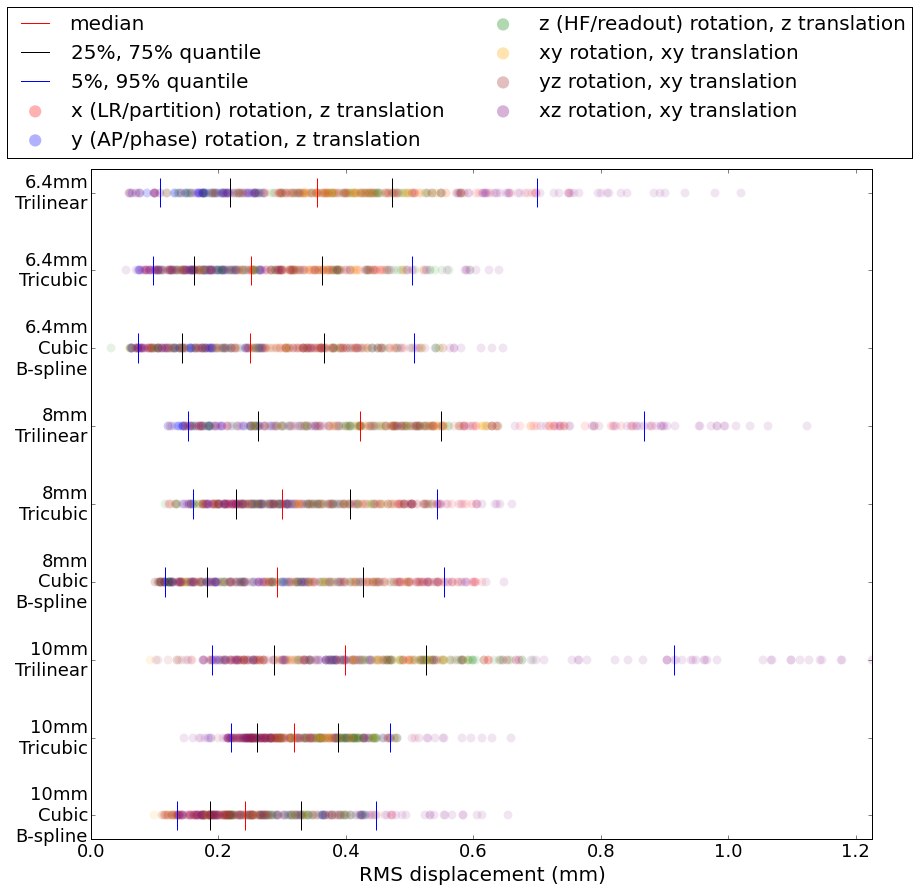

In [67]:
b_spline_quantiles, cubic_quantiles, linear_quantiles = error_plot_all([14,12], 1, 2, 3, True)

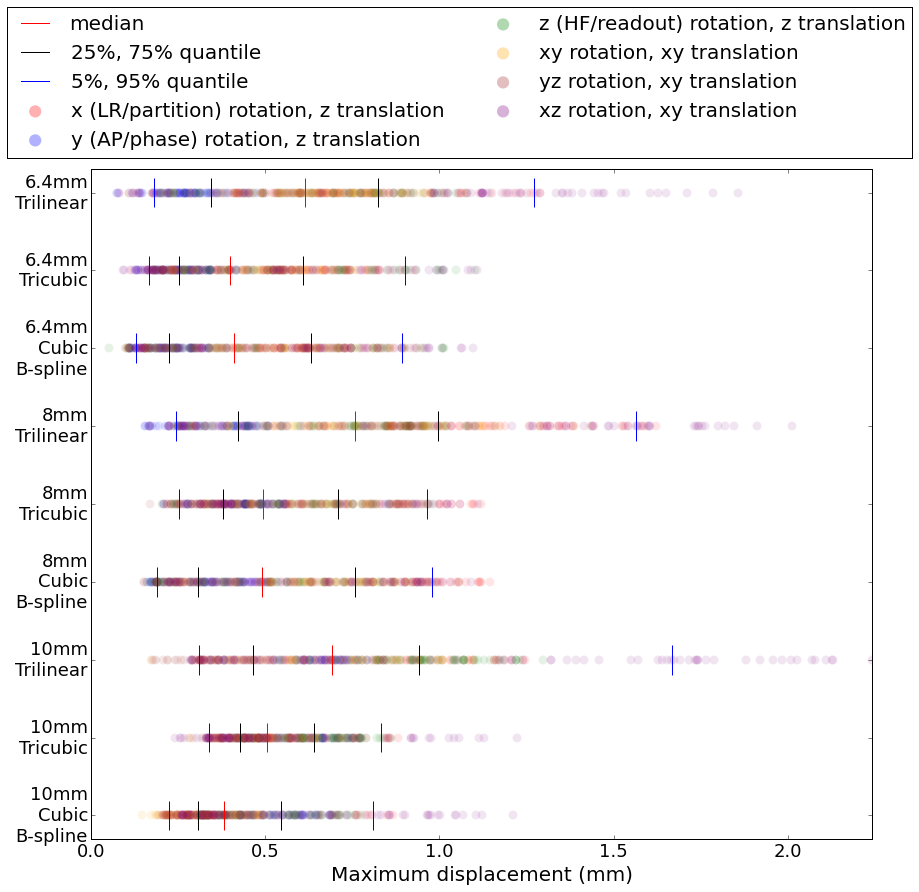

In [68]:
b_spline_quantiles_max, cubic_quantiles_max, linear_quantiles_max = error_plot_all([14,12], 10, 11, 12, False)

In [25]:
# Median values
idx_to_res = {3:6.4,2:8,1:10}
for i in xrange(3):
    print 'linear',idx_to_res[i+1], np.round(linear_quantiles[i][2],3)
    print 'cubic',idx_to_res[i+1], np.round(cubic_quantiles[i][2],3)
    print 'b-spline',idx_to_res[i+1], np.round(b_spline_quantiles[i][2],3)
    print

linear 10 0.399
cubic 10 0.318
b-spline 10 0.242

linear 8 0.423
cubic 8 0.3
b-spline 8 0.292

linear 6.4 0.355
cubic 6.4 0.252
b-spline 6.4 0.25



In [26]:
# Quantile prints across resolutions for RMS
quantiles = ['5%', '25%', 'median','75%', '95%']
for i in xrange(5):
    print '\n%s Quantile for 6.4, 8, 10, respectively' % quantiles[i]
    print 'trilinear'
    print '%.2f,%.2f,%.2f'% (linear_quantiles[2][i], linear_quantiles[1][i], linear_quantiles[0][i])
    
    print 'tricubic'
    print '%.2f,%.2f,%.2f'% (cubic_quantiles[2][i], cubic_quantiles[1][i], cubic_quantiles[0][i])
    
    print 'cubic b-spline'
    print '%.2f,%.2f,%.2f'% (b_spline_quantiles[2][i], b_spline_quantiles[1][i], b_spline_quantiles[0][i])


5% Quantile for 6.4, 8, 10, respectively
trilinear
0.11,0.15,0.19
tricubic
0.10,0.16,0.22
cubic b-spline
0.07,0.12,0.13

25% Quantile for 6.4, 8, 10, respectively
trilinear
0.22,0.26,0.29
tricubic
0.16,0.23,0.26
cubic b-spline
0.14,0.18,0.19

median Quantile for 6.4, 8, 10, respectively
trilinear
0.35,0.42,0.40
tricubic
0.25,0.30,0.32
cubic b-spline
0.25,0.29,0.24

75% Quantile for 6.4, 8, 10, respectively
trilinear
0.47,0.55,0.53
tricubic
0.36,0.41,0.39
cubic b-spline
0.37,0.43,0.33

95% Quantile for 6.4, 8, 10, respectively
trilinear
0.70,0.87,0.91
tricubic
0.50,0.54,0.47
cubic b-spline
0.51,0.55,0.45


In [27]:
# Quantile prints across resolutions for max displacement
quantiles = ['5%', '25%', 'median','75%', '95%']
for i in xrange(5):
    print '\n%s Quantile for 6.4, 8, 10, respectively' % quantiles[i]
    print 'trilinear'
    print '%.2f,%.2f,%.2f'% (linear_quantiles_max[2][i], linear_quantiles_max[1][i], linear_quantiles_max[0][i])
    
    print 'tricubic'
    print '%.2f,%.2f,%.2f'% (cubic_quantiles_max[2][i], cubic_quantiles_max[1][i], cubic_quantiles_max[0][i])
    
    print 'cubic b-spline'
    print '%.2f,%.2f,%.2f'% (b_spline_quantiles_max[2][i], b_spline_quantiles_max[1][i], b_spline_quantiles_max[0][i])


5% Quantile for 6.4, 8, 10, respectively
trilinear
0.18,0.24,0.31
tricubic
0.17,0.25,0.34
cubic b-spline
0.13,0.19,0.22

25% Quantile for 6.4, 8, 10, respectively
trilinear
0.34,0.42,0.47
tricubic
0.25,0.38,0.43
cubic b-spline
0.22,0.31,0.31

median Quantile for 6.4, 8, 10, respectively
trilinear
0.61,0.76,0.69
tricubic
0.40,0.49,0.51
cubic b-spline
0.41,0.49,0.38

75% Quantile for 6.4, 8, 10, respectively
trilinear
0.82,1.00,0.94
tricubic
0.61,0.71,0.64
cubic b-spline
0.63,0.76,0.54

95% Quantile for 6.4, 8, 10, respectively
trilinear
1.27,1.56,1.67
tricubic
0.90,0.96,0.83
cubic b-spline
0.89,0.98,0.81


In [28]:
# Quantile Comparison across resolutions
for i in xrange(5):
    print '\npercentage decrease from 10 to 8, 8 to 6.4', i
    print 'trilinear'
    print '%.2f,%.2f'%((linear_quantiles[1][i]-linear_quantiles[0][i])/linear_quantiles[0][i]*100, 
           (linear_quantiles[2][i]-linear_quantiles[1][i])/linear_quantiles[1][i]*100)
    
    print '\ntricubic'
    print '%.2f,%.2f'%((cubic_quantiles[1][i]-cubic_quantiles[0][i])/cubic_quantiles[0][i]*100, 
           (cubic_quantiles[2][i]-cubic_quantiles[1][i])/cubic_quantiles[1][i]*100)
    
    print '\ncubic b-spline'
    print '%.2f,%.2f'%((b_spline_quantiles[1][i]-b_spline_quantiles[0][i])/b_spline_quantiles[0][i]*100, 
           (b_spline_quantiles[2][i]-b_spline_quantiles[1][i])/b_spline_quantiles[1][i]*100)


percentage decrease from 10 to 8, 8 to 6.4 0
trilinear
-19.73,-29.07

tricubic
-27.09,-38.85

cubic b-spline
-14.25,-35.65

percentage decrease from 10 to 8, 8 to 6.4 1
trilinear
-8.56,-16.62

tricubic
-12.56,-28.61

cubic b-spline
-2.56,-21.20

percentage decrease from 10 to 8, 8 to 6.4 2
trilinear
6.03,-16.03

tricubic
-5.53,-16.20

cubic b-spline
20.39,-14.41

percentage decrease from 10 to 8, 8 to 6.4 3
trilinear
4.47,-13.99

tricubic
4.51,-10.64

cubic b-spline
29.32,-14.27

percentage decrease from 10 to 8, 8 to 6.4 4
trilinear
-5.15,-19.43

tricubic
15.80,-7.38

cubic b-spline
23.89,-8.55


In [61]:
# plotting quantiles
def error_plot_rotations_translations_2(figsize, r_idx_6_4, r_idx_8, r_idx_10, t_idx_6_4, t_idx_8, t_idx_10, RMS = True):
    colors = ['red','blue','green','orange','brown','purple']
    quantile_colors = ['blue','black','red','black','blue']
    y = np.arange(1,10)
    labels = ['10mm\nCubic\nB-spline','10mm\nTricubic','10mm\nTrilinear',
              '8mm\nCubic\nB-spline','8mm\nTricubic','8mm\nTrilinear',
              '6.4mm\nCubic\nB-spline','6.4mm\nTricubic','6.4mm\nTrilinear']
    
    plt.figure(figsize = figsize)
    
    plt.subplot(1,2,1)
    plt.yticks(y, labels, rotation='horizontal',fontsize=18)
    plt.xticks(fontsize=18)
    for idx, rot_ax in enumerate(['x','y','z','xy','yz','xz']):
        if rot_ax == 'x':
            label = 'x (LR/partition) rotation, z translation'
        elif rot_ax == 'y':
            label = 'y (AP/phase) rotation, z translation'
        elif rot_ax == 'z':
            label = 'z (HF/readout) rotation, z translation'
        else: 
            label = rot_ax + " rotation, xy translation"
        plt.scatter(-3, -3, lw=0,s = 150, c = colors[idx],alpha = 0.3,marker='o' , label=label)
    plt.plot([-4,-5],[-4,-5],lw=1,c='red',label='median')
    plt.plot([-4,-5],[-4,-5],lw=1,c='black',label='25%, 75% quantile')
    plt.plot([-4,-5],[-4,-5],lw=1,c='blue',label='5%, 95% quantile')
    
    idx = 1
    error_plot(RMS_bspline[r_idx_10],idx)
    print np.percentile(np.array(RMS_bspline[r_idx_10]),[5,25,50,75,95])
    plt.vlines(np.percentile(np.array(RMS_bspline[r_idx_10]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1 
    error_plot(RMS_cubic[r_idx_10],idx)
    plt.vlines(np.percentile(np.array(RMS_cubic[r_idx_10]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_linear[r_idx_10],idx)
    plt.vlines(np.percentile(np.array(RMS_linear[r_idx_10]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_bspline[r_idx_8],idx)
    plt.vlines(np.percentile(np.array(RMS_bspline[r_idx_8]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_cubic[r_idx_8],idx)
    plt.vlines(np.percentile(np.array(RMS_cubic[r_idx_8]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_linear[r_idx_8],idx)
    plt.vlines(np.percentile(np.array(RMS_linear[r_idx_8]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_bspline[r_idx_6_4],idx)
    plt.vlines(np.percentile(np.array(RMS_bspline[r_idx_6_4]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_cubic[r_idx_6_4],idx)
    plt.vlines(np.percentile(np.array(RMS_cubic[r_idx_6_4]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_linear[r_idx_6_4],idx)
    plt.vlines(np.percentile(np.array(RMS_linear[r_idx_6_4]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    plt.vlines(0,0,7,color = 'r',lw=1,linestyle='--')
    plt.ylim([0.7,9.3])
    plt.legend(loc='center left', bbox_to_anchor=(-0.28, 1.13), ncol=2, scatterpoints=1,fontsize = 20)
    #plt.title('Rotation RMS',fontsize = 20)
    if(RMS):
        plt.xlim([0,xlim_max_rot_rms])
        plt.xlabel('Rotation Error (degrees)',fontsize=20)
    else:
        plt.xlim([0,1.2])
        plt.xlabel('Maximum displacement\ndue to rotation (mm)',fontsize=20)
    plt.grid('off')

    plt.subplot(1,2,2)
    plt.yticks([])
    plt.xticks(fontsize=18)
    
    idx = 1
    error_plot(RMS_bspline[t_idx_10],idx)
    print np.percentile(np.array(RMS_bspline[t_idx_10]),[5,25,50,75,95])
    plt.vlines(np.percentile(np.array(RMS_bspline[t_idx_10]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1 
    error_plot(RMS_cubic[t_idx_10],idx)
    plt.vlines(np.percentile(np.array(RMS_cubic[t_idx_10]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_linear[t_idx_10],idx)
    plt.vlines(np.percentile(np.array(RMS_linear[t_idx_10]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_bspline[t_idx_8],idx)
    plt.vlines(np.percentile(np.array(RMS_bspline[t_idx_8]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_cubic[t_idx_8],idx)
    plt.vlines(np.percentile(np.array(RMS_cubic[t_idx_8]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_linear[t_idx_8],idx)
    plt.vlines(np.percentile(np.array(RMS_linear[t_idx_8]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_bspline[t_idx_6_4],idx)
    plt.vlines(np.percentile(np.array(RMS_bspline[t_idx_6_4]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_cubic[t_idx_6_4],idx)
    plt.vlines(np.percentile(np.array(RMS_cubic[t_idx_6_4]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_linear[t_idx_6_4],idx)
    plt.vlines(np.percentile(np.array(RMS_linear[t_idx_6_4]),[5,25,50,75,95]),idx-0.19,idx+0.19,lw=1,color=quantile_colors)
    
    plt.vlines(0,0,7,color = 'r',lw=1,linestyle='--')
    if(RMS):
        plt.xlim([0,xlim_max_trans])
        plt.xlabel('Translation Error (mm)',fontsize=20)
    else:
        plt.xlim([0,1.2])
        plt.xlabel('RMS displacemnt\ndue to rotation (mm)',fontsize=20)
    plt.ylim([0.7,9.3])
    plt.grid('off')
    
    plt.show()

[ 0.05436004  0.08628022  0.12426408  0.1853037   0.36625372]
[ 0.06396681  0.11918678  0.17032433  0.23061064  0.34666164]


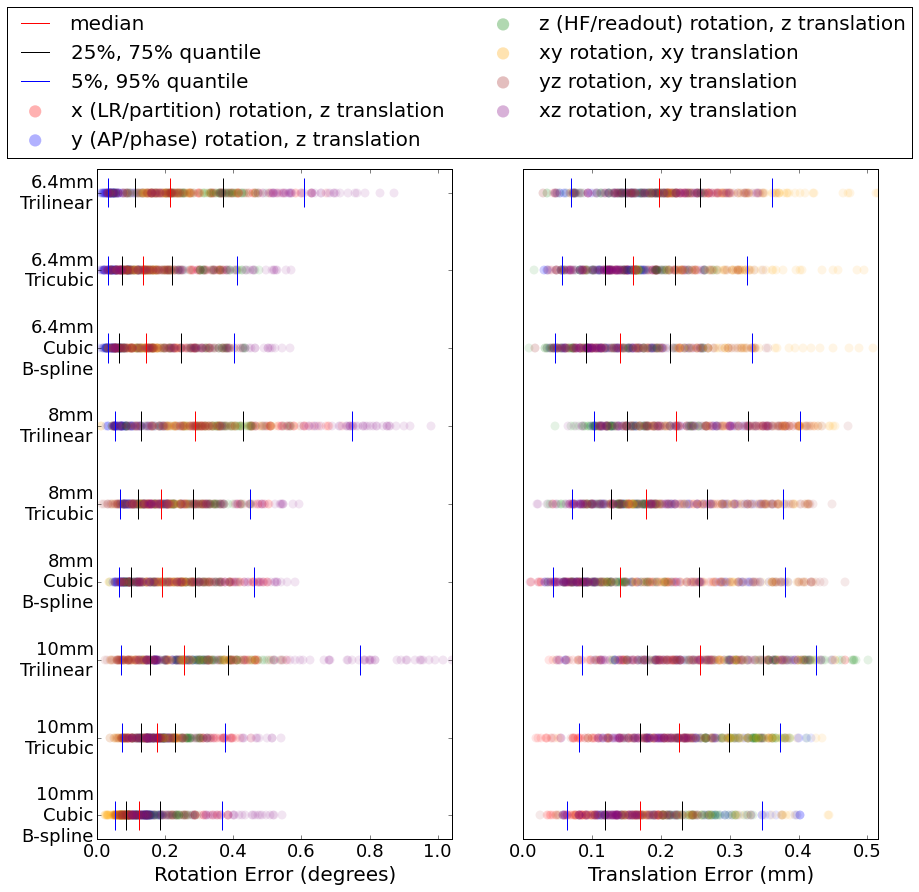

In [57]:
error_plot_rotations_translations_2([14,12], 4, 5, 6, 7, 8, 9, True)

[ 0.09487617  0.15058738  0.21688169  0.32341582  0.63923224]
[ 0.06000496  0.09523982  0.13716802  0.20454613  0.40428597]


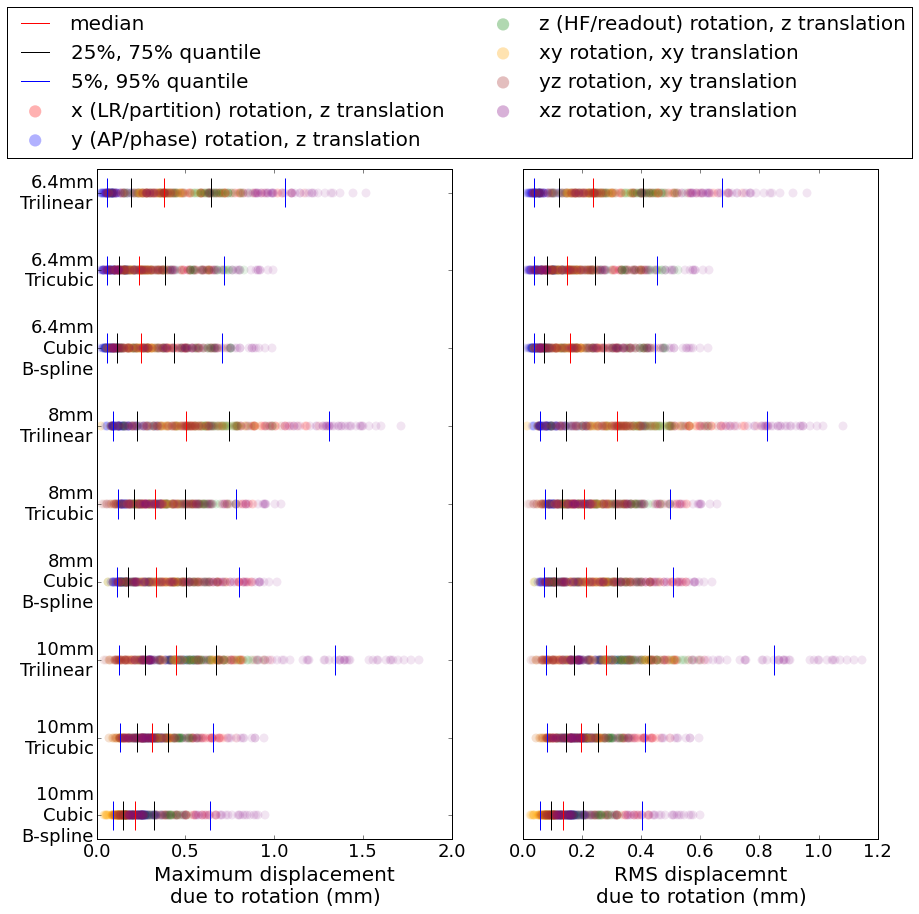

In [59]:
error_plot_rotations_translations_2([14,12], 13, 14, 15, 16, 17, 18, False)

[ 0.06396681  0.11918678  0.17032433  0.23061064  0.34666164]
[ 0.06000496  0.09523982  0.13716802  0.20454613  0.40428597]


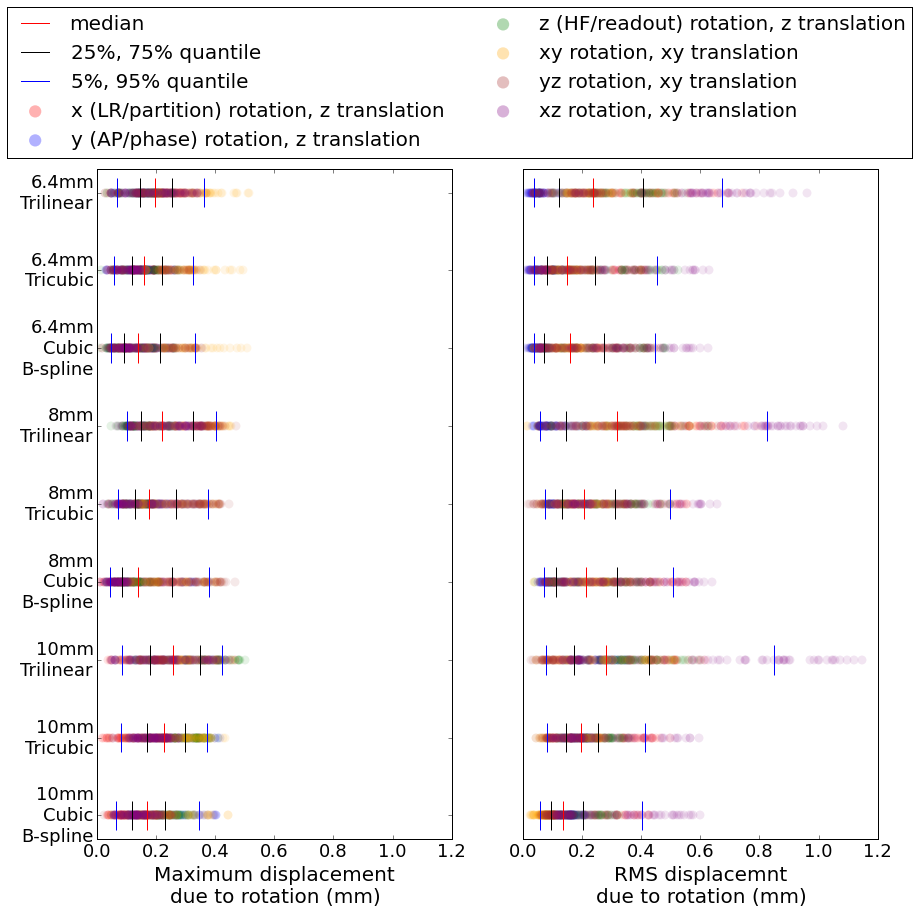

In [64]:
error_plot_rotations_translations_2([14,12], 7, 8, 9, 16,17,18,False )

In [65]:
# plotting quantiles separating rotations and translations
def error_plot_rotations_translations(figsize):
    colors = ['red','blue','green','orange','brown','purple']
    quantile_colors = ['blue','black','red','black','blue']
    y = np.arange(1,19)
    labels = ['Rotation','10mm\nCubic B-spline\nTranslation',
              'Rotation','10mm\nTricubic\nTranslation',
              'Rotation','10mm\nTrilinear\nTranslation',
              'Rotation','8mm\nCubic B-spline\nTranslation',
              'Rotation','8mm\nTricubic\nTranslation',
              'Rotation','8mm\nTrilinear\nTranslation',
              'Rotation','6.4mm\nCubic B-spline\nTranslation',
              'Rotation','6.4mm\nTricubic\nTranslation',
              'Rotation','6.4mm\nTrilinear\nTranslation']
    plt.figure(figsize = figsize)
    plt.yticks(y, labels, rotation='horizontal',fontsize=14)
    plt.xticks(fontsize=18)
    for idx, rot_ax in enumerate(['x','y','z','xy','yz','xz']):
        if rot_ax == 'x':
            label = 'x (LR/partition) rotation, z translation'
        elif rot_ax == 'y':
            label = 'y (AP/phase) rotation, z translation'
        elif rot_ax == 'z':
            label = 'z (HF/readout) rotation, z translation'
        else: 
            label = rot_ax + " rotation, xy translation"
        plt.scatter(-3, -3, lw=0,s = 30, c = colors[idx],alpha = 0.3,marker='o' , label=label)
    plt.plot([-4,-5],[-4,-5],lw=1,c='red',label='median')
    plt.plot([-4,-5],[-4,-5],lw=1,c='black',label='25%, 75% quantile')
    plt.plot([-4,-5],[-4,-5],lw=1,c='blue',label='5%, 95% quantile')

    idx = 1
    error_plot(RMS_bspline[6],idx)
    plt.vlines(np.percentile(np.array(RMS_bspline[6]),[5,25,50,75,95]),idx-0.1,idx+0.1,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_bspline[9],idx)
    plt.vlines(np.percentile(np.array(RMS_bspline[9]),[5,25,50,75,95]),idx-0.1,idx+0.1,lw=1,color=quantile_colors)
    
    idx += 1 
    error_plot(RMS_cubic[6],idx)
    plt.vlines(np.percentile(np.array(RMS_cubic[6]),[5,25,50,75,95]),idx-0.1,idx+0.1,lw=1,color=quantile_colors)

    idx += 1 
    error_plot(RMS_cubic[9],idx)
    plt.vlines(np.percentile(np.array(RMS_cubic[9]),[5,25,50,75,95]),idx-0.1,idx+0.1,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_linear[6],idx)
    plt.vlines(np.percentile(np.array(RMS_linear[6]),[5,25,50,75,95]),idx-0.1,idx+0.1,lw=1,color=quantile_colors)
 
    idx += 1
    error_plot(RMS_linear[9],idx)
    plt.vlines(np.percentile(np.array(RMS_linear[9]),[5,25,50,75,95]),idx-0.1,idx+0.1,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_bspline[5],idx)
    plt.vlines(np.percentile(np.array(RMS_bspline[5]),[5,25,50,75,95]),idx-0.1,idx+0.1,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_bspline[8],idx)
    plt.vlines(np.percentile(np.array(RMS_bspline[8]),[5,25,50,75,95]),idx-0.1,idx+0.1,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_cubic[5],idx)
    plt.vlines(np.percentile(np.array(RMS_cubic[5]),[5,25,50,75,95]),idx-0.1,idx+0.1,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_cubic[8],idx)
    plt.vlines(np.percentile(np.array(RMS_cubic[8]),[5,25,50,75,95]),idx-0.1,idx+0.1,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_linear[5],idx)
    plt.vlines(np.percentile(np.array(RMS_linear[5]),[5,25,50,75,95]),idx-0.1,idx+0.1,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_linear[8],idx)
    plt.vlines(np.percentile(np.array(RMS_linear[8]),[5,25,50,75,95]),idx-0.1,idx+0.1,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_bspline[4],idx)
    plt.vlines(np.percentile(np.array(RMS_bspline[4]),[5,25,50,75,95]),idx-0.1,idx+0.1,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_bspline[7],idx)
    plt.vlines(np.percentile(np.array(RMS_bspline[7]),[5,25,50,75,95]),idx-0.1,idx+0.1,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_cubic[4],idx)
    plt.vlines(np.percentile(np.array(RMS_cubic[4]),[5,25,50,75,95]),idx-0.1,idx+0.1,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_cubic[7],idx)
    plt.vlines(np.percentile(np.array(RMS_cubic[7]),[5,25,50,75,95]),idx-0.1,idx+0.1,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_linear[4],idx)
    plt.vlines(np.percentile(np.array(RMS_linear[4]),[5,25,50,75,95]),idx-0.1,idx+0.1,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_linear[7],idx)
    plt.vlines(np.percentile(np.array(RMS_linear[7]),[5,25,50,75,95]),idx-0.1,idx+0.1,lw=1,color=quantile_colors)
    
    plt.vlines(0,0,7,color = 'r',lw=1,linestyle='--')
    plt.xlim([0,0.5])
    plt.ylim([0.8,18.2])
    plt.legend(loc='center left', bbox_to_anchor=(0.02, 1.08), ncol=3)
    plt.title('RMS Comparison',fontsize = 20)
    plt.xlabel('RMS displacement',fontsize=20)
    plt.grid('off')
    plt.show()